In [83]:
import os
import conllu
import pandas as pd

In [84]:
path_agregated_cvs = "/home/wran/Research/memoire/experimentations_notebooks/data/6_cvs/agregated_cvs.conllu"

In [85]:
with open(path_agregated_cvs, 'r') as infile:
    parsed_conllu = conllu.parse(infile.read())

In [86]:
n_true_sequences = {}
n_true_tokens = {}

properties = ['head', 'deprel', 'pos', 'LA']
for property_ in properties:
    n_true_sequences[property_] = 0
    n_true_tokens[property_] = 0

In [87]:
n_total_sequences = 0
n_total_tokens = 0
n_true_sequences = {}
n_true_tokens = {}

properties = ['head', 'deprel', 'pos', 'LA']
for property_ in properties:
    n_true_sequences[property_] = 0
    n_true_tokens[property_] = 0
    
df_labels = []
for property_ in properties:
    df_labels += ["{}_{}".format(property_, truthiness) for truthiness in ["true", "false"]]    
df = pd.DataFrame(columns=["sequence_len"] + df_labels)
    
for i, sequence in enumerate(parsed_conllu):
    sequence_true = {}
    for property_ in properties:
        sequence_true[property_] = 0
        
    sequence_len = (len(sequence))
    
    for token in sequence:
        head_pred = int(token['misc']['head_MST'])
        head_true = int(token['head'])
        
        deprel_pred = (token['misc']['deprel_main_pred'])
        deprel_true = (token['deprel'])
        
        pos_pred = token['upos']
        pos_true = (token['misc']['upostag'])

        
        head_correct, deprel_correct = False, False
        if head_pred == head_true:
            sequence_true['head'] += 1
            head_correct = True
        
        if deprel_pred == deprel_true:
            sequence_true['deprel'] += 1
            deprel_correct = True
            
        if (head_correct) & (deprel_correct):
            sequence_true['LA'] += 1
            
        if pos_pred == pos_true: 
            sequence_true['pos'] += 1
    
    dict_sequence = {}
    
    for property_ in properties:
        n_true_sequences[property_] += int(sequence_true[property_] == sequence_len)
        n_true_tokens[property_] += sequence_true[property_]
        dict_sequence["{}_true".format(property_)] = sequence_true[property_]
        dict_sequence["{}_false".format(property_)] = sequence_len - sequence_true[property_]
    
    n_total_sequences += 1
    n_total_tokens += sequence_len
    dict_sequence["sequence_len"] = sequence_len
    
    df = df.append(dict_sequence, ignore_index=True)
    
for property_ in properties:
    print(property_)
    print("{:.1f}% sentences correct ({}/{})".format(100*n_true_sequences[property_]/n_total_sequences, n_true_sequences[property_], n_total_sequences))
    print("{:.1f}% tokens correct ({}/{})".format(100*n_true_tokens[property_]/n_total_tokens, n_true_tokens[property_], n_total_tokens))
    print()

head
65.5% sentences correct (5410/8259)
94.2% tokens correct (123475/131042)

deprel
54.0% sentences correct (4461/8259)
94.0% tokens correct (123226/131042)

pos
65.4% sentences correct (5400/8259)
96.8% tokens correct (126862/131042)

LA
46.7% sentences correct (3860/8259)
90.5% tokens correct (118531/131042)



In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [7]:
sns.set(color_codes=True)

In [58]:
import matplotlib as mpl
import brewer2mpl
# brewer2mpl.get_map args: set name  set type  number of colors
bmap = brewer2mpl.get_map('Set1', 'qualitative', 4)
colors = bmap.mpl_colors

params = {
   'axes.labelsize': 8,
 #  'text.fontsize': 8,
   'legend.fontsize': 10,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [10, 5]
   }
mpl.rcParams.update(params)

In [69]:
print(df["sequence_len"].sum())
print(df["sequence_len"].mean())
print(df["sequence_len"].std())

131042
15.866569802639544
12.193627166008156


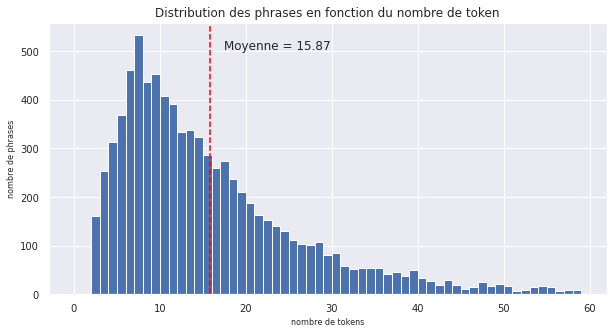

In [82]:
x = df["sequence_len"]


sum = x.sum()
mean = x.mean()
std = x.std()


plt.hist(x, bins=range(0,60), label="distribution")
plt.axvline(mean, color="red", linestyle="--")
plt.xlabel("nombre de tokens")
plt.ylabel("nombre de phrases")
plt.title("Distribution des phrases en fonction du nombre de token")

min_ylim, max_ylim = plt.ylim()
plt.text(x.mean()*1.1, max_ylim*0.9, 'Moyenne = {:.2f}'.format(mean))
plt.plot()

for ext_file in ['png', 'svg']:
    plt.savefig("fig_sentences_distribution." + ext_file, format=ext_file)

In [60]:
list_all_deprel = []

list_failed_deprel = []
couple_all_deprel_failed = []

couple_restricted_deprel_fail = []
couple_under_specified = []
couple_over_specified = []

list_deprel_true = []
list_deprel_pred = []
list_succeed_deprel = []
list_succeed_head = []
list_token_head = []
list_token_dep = []
list_syn_dist = []
list_sequence_len = []
for i, sequence in enumerate(parsed_conllu):
    for token in sequence:
        dict_row = {}
        list_all_deprel.append(deprel_true)
        list_syn_dist.append(int(token["head"])- int(token['id']))
        list_sequence_len.append(len(sequence))
        
        deprel_pred = (token['misc']['deprel_main_pred'])
        deprel_true = (token['deprel'])
        list_deprel_true.append(deprel_true)
        list_deprel_pred.append(deprel_pred)
        
        list_token_head.append(sequence[token["head"]-1]["form"])
        list_token_dep.append(token["form"])
        if deprel_pred.replace("@", ":") != deprel_true.replace("@", ":"):
            couple_relation = "{}___{}".format(deprel_true, deprel_pred)
            if deprel_true in deprel_pred:
                couple_over_specified.append(couple_relation)
            
            elif deprel_pred in deprel_true:
                couple_under_specified.append(couple_relation)
                
            else:
                couple_restricted_deprel_fail.append(couple_relation)                
                list_failed_deprel.append(deprel_true)
                succeed_deprel = 0
            couple_all_deprel_failed.append(couple_relation)
        
        else:
            succeed_deprel = 1
        
        head_pred = int(token['misc']['head_MST'])
        head_true = int(token['head'])
        
        if head_pred == head_true:
            succeed_head = 1
        else:
            succeed_head = 0
        
        list_succeed_deprel.append(succeed_deprel)
        list_succeed_head.append(succeed_head)
            
        
        

In [61]:
data = zip(
    list_deprel_true, 
    list_deprel_pred, 
    list_succeed_deprel, 
    list_succeed_head,
    list_token_head,
    list_token_dep,
    list_syn_dist,
    list_sequence_len,
)
df_deprel = pd.DataFrame(data,columns=["deprel_true", "deprel_pred", "succeed_deprel", "succeed_head",
                                      "token_head", "token_dep", "syn_dist", 'sequence_len'])


[]

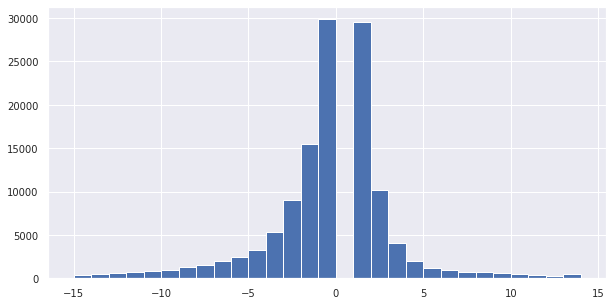

In [65]:
plt.hist(df_deprel["syn_dist"], bins=range(-15,15))
plt.plot()

In [247]:
from collections import Counter

On peut voir dans les trois cellules suivantes que sur nos 7500 erreurs globales de mauvais etiquettage de la fonction, 10% (700) sont liées à une sous-spécification de la fonction (mod à la place de mod:emph) et 10% sont liées à une sur-spécification (mod:emph au lieu de mod). 
Ces erreurs, qui representent 20% de nos erreures de labelisation, ne sont pas de graves erreurs mais peuvent entre autre nous aider à déceler des ambiguités d'annotations 

In [248]:
print(len(list_all_deprel_failed))

7792


In [249]:
print(len(list_under_specified))
Counter(list_under_specified).most_common(10)

699


[('mod:emph___mod', 128),
 ('subj@expl___subj', 85),
 ('mod:periph___mod', 72),
 ('comp:obj@lvc___comp:obj', 52),
 ('comp:obj@x___comp:obj', 34),
 ('comp:pred@fixed___comp:pred', 34),
 ('root@scrap___root', 33),
 ('comp:obj@scrap___comp:obj', 26),
 ('mod:poss___mod', 26),
 ('det:num___det', 23)]

In [250]:
print(len(list_over_specified))
Counter(list_over_specified).most_common(10)

638


[('mod___mod:periph', 118),
 ('mod___mod:poss', 99),
 ('mod___mod:emph', 63),
 ('subj___subj:expl', 62),
 ('comp:obj___comp:obj:x', 40),
 ('comp:pred___comp:pred:fixed', 39),
 ('mod___mod:relcl', 32),
 ('root___root:scrap', 31),
 ('comp:obj___comp:obj:lvc', 23),
 ('comp:obj___comp:obj:scrap', 19)]

In [251]:
print(len(couple_deprel_fail))
Counter(couple_deprel_fail).most_common(10)

6455


[('mod___comp:obl', 260),
 ('mod___compound', 195),
 ('mod___comp:obj', 169),
 ('comp:obj___mod', 163),
 ('comp:obl___mod', 163),
 ('comp:obj@x___comp:aux', 148),
 ('compound___mod', 142),
 ('dislocated___mod:periph', 89),
 ('mod___comp:pred', 82),
 ('comp:pred___comp:obj', 78)]

In [252]:
ctr_all_deprel = Counter(list_all_deprel)
ctr_failed_deprel = Counter(list_failed_deprel)
for deprel, all_count in ctr_all_deprel.most_common():
    print(deprel, all_count, ctr_failed_deprel[deprel])

punct 37171 1
comp:obj 17775 702
subj 12180 256
mod 9541 1004
comp:aux 8236 194
root 8222 364
det 4816 45
comp:pred 3293 311
discourse 2551 206
mod:periph 2439 210
comp:obl 2048 226
cc 1995 83
mod@relcl 1920 117
conj:coord 1844 297
mod:poss 1728 23
conj:dicto 1479 96
dislocated 1369 275
comp:cleft 1239 97
compound 1094 259
mod:emph 1076 61
comp:obj@x 1011 245
compound:svc 958 135
parataxis:conj 880 61
parataxis:obj 672 62
unk@fixed 578 119
flat 546 164
compound:redup 531 25
det:num 383 28
compound:prt 348 43
comp:obl@x 256 40
subj@expl 247 1
comp:obj@fixed 244 59
comp:pred@fixed 229 7
root@scrap 202 18
conj:appos 178 39
vocative 177 51
mod:num 174 53
comp:obj@scrap 168 32
flat:foreign 159 56
parataxis:discourse 139 57
parataxis:parenth 119 33
comp:obj@agent 107 27
comp:obj@lvc 101 17
comp:pred@agent 96 17
unk@scrap 72 54
parataxis:dislocated 68 40
comp:aux@scrap 52 10
mod:relcl 48 1
mod@fixed 37 11
mod:appos 29 26
det@num 26 2
comp:cleft@scrap 21 11
comp:pred@scrap 20 12
mod@scrap 20 1

In [286]:
ctr_all_words = Counter(list(df_deprel["token_dep"]))

In [287]:
ctr_all_words.most_common()

[('#', 10829),
 ('//', 6867),
 ('dey', 3817),
 ('<', 3608),
 ('go', 2935),
 ('I', 2884),
 ('di', 2630),
 ('{', 2521),
 ('}', 2521),
 ('you', 2327),
 ('na', 1823),
 ('[', 1721),
 ('for', 1690),
 ('no', 1609),
 ('|c', 1565),
 ('sey', 1558),
 ('||', 1522),
 ('e', 1509),
 ('wey', 1413),
 ('we', 1298),
 ('am', 1279),
 (']', 1216),
 ('de', 1158),
 ('so', 1078),
 ('con', 1045),
 ('be', 949),
 ('and', 919),
 ('>+', 902),
 ('dat', 888),
 ('to', 864),
 ('me', 860),
 ('dis', 851),
 ('dem', 816),
 ('//=', 816),
 ('one', 813),
 ('my', 782),
 ('do', 771),
 ('don', 762),
 ('make', 719),
 ('of', 715),
 ('im', 711),
 ('now', 706),
 ('come', 683),
 ('if', 678),
 ('say', 671),
 ('get', 662),
 ('o', 572),
 ('like', 553),
 ('your', 521),
 ('|r', 509),
 ('?//', 508),
 ('as', 490),
 ('!//', 476),
 ('people', 467),
 ('know', 451),
 ('but', 433),
 ('just', 427),
 ('see', 422),
 ('&//', 406),
 ('eh', 403),
 ('wetin', 395),
 ('fit', 369),
 ('because', 365),
 ('tell', 361),
 ('wan', 352),
 ('all', 341),
 ('talk',

In [294]:
for token, count_fail in Counter(list(df_deprel[df_deprel["succeed_deprel"] == 0]["token_dep"])).most_common():
    print(token, count_fail, "{:.0f}%".format(100*count_fail/ctr_all_words[token]))

for 278 16%
dey 251 7%
to 215 25%
like 119 22%
go 117 4%
sey 117 8%
now 104 15%
na 71 4%
make 69 10%
be 67 7%
one 63 8%
as 63 13%
of 56 8%
in 56 25%
wey 55 4%
inside 49 17%
say 47 7%
on 47 21%
so 45 4%
two 43 26%
me 42 5%
dat 40 5%
come 39 6%
con 37 4%
know 37 8%
people 36 8%
don 36 5%
five 36 27%
get 33 5%
you 33 1%
all 30 9%
because 29 8%
from 29 12%
e 29 2%
wetin 28 7%
no 28 2%
time 27 13%
dem 27 3%
dere 27 13%
day 27 22%
do 25 3%
if 25 4%
im 23 3%
nine 22 55%
see 22 5%
we 22 2%
wan 21 6%
by 21 26%
I 21 1%
am 20 2%
dis 20 2%
naira 20 22%
how 19 9%
God 19 7%
three 18 19%
meh 17 9%
twenty 17 27%
take 16 5%
when 16 5%
man 16 8%
a 16 10%
den 16 9%
outside 16 36%
who 16 28%
give 16 7%
with 16 14%
di 16 1%
why 15 15%
is 15 11%
ninety 15 62%
money 15 5%
Nigeria 15 13%
wit 14 16%
person 14 7%
own 14 10%
year 14 17%
o 14 2%
top 14 17%
small 13 6%
morning 13 21%
six 13 25%
place 13 10%
Alaska 13 37%
ting 12 5%
bitter 12 75%
thousand 12 16%
woman 11 11%
reach 11 9%
number 11 23%
my 11 1%
way 1

injury 1 25%
Vice 1 100%
cr- 1 100%
member 1 25%
Manager 1 100%
section 1 11%
relation 1 100%
embarrassing 1 100%
terms 1 100%
do- 1 50%
biko 1 100%
package 1 10%
We 1 100%
Don 1 100%
Hear 1 100%
Front 1 100%
allright 1 100%
www 1 100%
Government 1 7%
fake 1 20%
Ekiti 1 100%
Assemble 1 50%
Governor 1 50%
times 1 7%
Controller 1 100%
NIS 1 100%
Inland 1 100%
FR 1 100%
e-services 1 100%
NJC 1 100%
Mrs 1 25%
Had- 1 100%
LASIEC 1 100%
All 1 100%
Progressive 1 100%
chairmo 1 50%
bank 1 20%
terror 1 100%
Bank 1 33%
CBN 1 100%
ahead 1 25%
walahi 1 100%
quit 1 100%
spark 1 100%
kd 1 100%
shorten 1 100%
shun 1 100%
silva 1 100%
fried 1 100%
blend 1 20%
dash 1 100%
bringing 1 100%
feel 1 4%
somebody 1 8%
en- 1 100%
mon- 1 100%
sliding 1 100%
case 1 14%
swing 1 50%
door 1 8%
remaining 1 25%
hence 1 100%
tree 1 14%
control 1 17%
teach 1 2%
kukuma 1 20%
yesterday 1 5%
ba 1 14%
ke 1 50%
nan 1 100%
tuwo 1 100%
gaskiya 1 50%
sosei 1 100%
Bariga 1 17%
Emmanuel 1 33%
High 1 50%
n- 1 33%
m- 1 25%
resume 

In [ ]:
ctr_all_words[token]

In [282]:
df_deprel[df_deprel["succeed_deprel"] == 0].groupby("token_dep").sum()

,succeed_deprel,succeed_head
token_dep,,
!//=,0,1
##,0,0
&//,0,0
's,0,0
*,0,0
...,...,...
your,0,2
yoursef,0,1
youths,0,0


In [40]:
df_deprel

,deprel_true,deprel_pred,succeed_deprel,succeed_head,token_head,token_dep,syn_dist,sequence_len
0,subj,subj,1,0,dey,life,6,11
1,mod,root,0,0,life,for,-1,11
2,comp:obj,comp:obj,1,1,for,me,-1,11
3,mod,mod,1,0,life,as,-3,11
4,mod,mod,1,1,pikin,small,1,11
...,...,...,...,...,...,...,...,...
131037,mod,compound,0,1,version,English,1,12
131038,comp:obj,comp:obj,1,1,hear,version,-3,12
131039,mod,mod,1,1,version,of,-1,12
131040,comp:obj,comp:obj,1,1,of,me,-1,12
